In [1]:
# Importing necessary libraries

import sys
import urllib
import pandas as pd 
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import spacy
warnings.filterwarnings('ignore')
from torchtext.legacy.data import get_tokenizer

plt.style.use('ggplot')

Find hypothesis about the data

What questions do I want to answer? What value do I want from this project?

Explainability models (calculates backwards, what words have the most impact on the prediction) 

Can we change an attacking comment so the model does not think it is

FIND SOURCES - is this already a discussion, a problem that is defined in different contexts



In [2]:
# URLs for the datasets for 'personal attacks': annotated comments, annotations, and crowdsourcer demographics

#ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634'
#ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637'
#DEMOGRAPHICS_URL = 'https://ndownloader.figshare.com/files/7640752'

In [3]:
# Download function
def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

In [4]:
#download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
#download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')
#download_file(DEMOGRAPHICS_URL, 'attack_worker_demographics.tsv')

In [5]:
comments = pd.read_csv('Data/attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('Data/attack_annotations.tsv',  sep = '\t')
demographics = pd.read_csv('Data/attack_worker_demographics.tsv', sep = '\t')

Dataframes explained:
- comments: contains the annotated comments
- annotations: contains the annotated comments (labels); different types of attack
- demographics: contains information about the crowd-workers

Goal: given a comment, predict whether the comment is a personal attack or not.

In [6]:
print(demographics.shape)
print(comments.shape)
annotations.shape

(2190, 5)
(115864, 6)


(1365217, 7)

In [7]:
# Labels are decided through majority vote (One-hot) 
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [8]:
comments['attack'] = labels
print(comments.columns)

Index(['comment', 'year', 'logged_in', 'ns', 'sample', 'split', 'attack'], dtype='object')


In [9]:
# How many authors/people who comment
len(annotations['rev_id'].unique())

115864

In [10]:
# Attack will be changed to: 1 if a comment consist a personal attack and 0 otherwise
comments['attack'] = comments['attack'].astype('int')

In [11]:
comments['dup'] = comments.duplicated(subset=None, keep='first')

In [12]:
comments['dup'].value_counts()

False    115808
True         56
Name: dup, dtype: int64

In [13]:
comments = comments[comments['dup'] == False]
del comments['dup'] # deleting "dup" column 

In [14]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# data cleaning
stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.remove('no')
comments['comment'] = comments['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])) # removing stopwords
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " ")) # remove NEWLINE_TOKEN
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " ")) # remove TAB_TOKEN
comments["comment"] = comments['comment'].str.replace(r'[^\w\s]+', '') # remove punctuation
comments["comment"] = comments['comment'].str.replace(r'\d+', '') # Remove nuumbers
comments.head()

comment  year  logged_in  \
rev_id                                                                       
37675    This not creative Those dictionary definition...  2002      False   
44816      term standard model less NPOV I think wed p...  2002      False   
49851     True false situation March  such  A Saudi pr...  2002      False   
89320   Next maybe could work less condescending sugge...  2002       True   
93890                       This page need disambiguation  2002       True   

             ns  sample  split  attack  
rev_id                                  
37675   article  random  train       0  
44816   article  random  train       0  
49851   article  random  train       0  
89320   article  random    dev       0  
93890   article  random  train       0

In [16]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

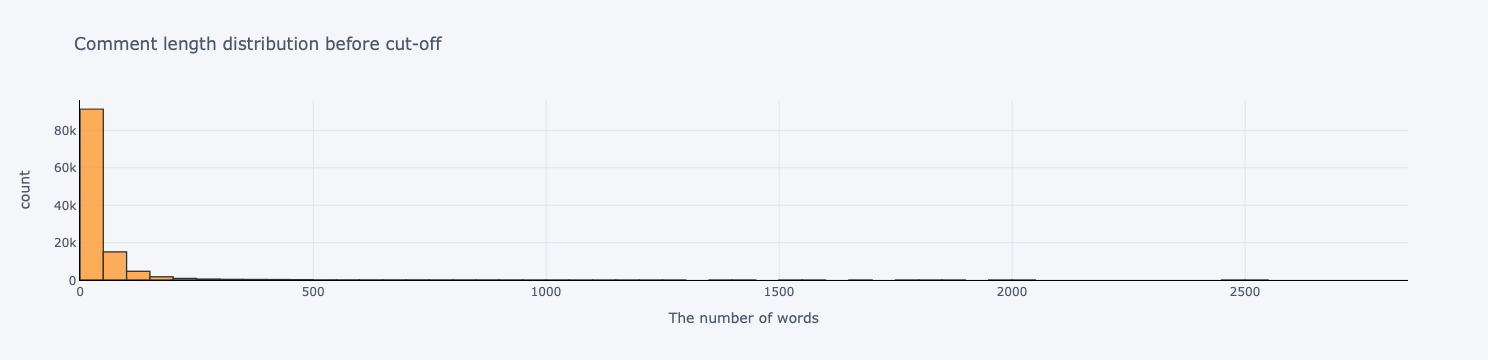

In [17]:
# length of comments before cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
comments['comment_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='The number of words',
    linecolor='black',
    yTitle='count',
    title='Comment length distribution before cut-off')

In [18]:
np.mean(comments['comment'].apply(lambda x: len(x.split()))) # mean length of comment
comments['comment'].count()

115808

In [19]:
# Max number of words in each comment; the mean of all comments is app. 69, 
MAX_SEQUENCE_LENGTH = 200
def comment_cut_off(x):
    x = x.split(maxsplit=MAX_SEQUENCE_LENGTH)
    x = ' '.join(x[:MAX_SEQUENCE_LENGTH])
    return x

In [20]:
comments['comment'] = comments['comment'].apply(comment_cut_off)
comments.drop(comments[comments.comment.str.len() < 5].index, inplace=True)

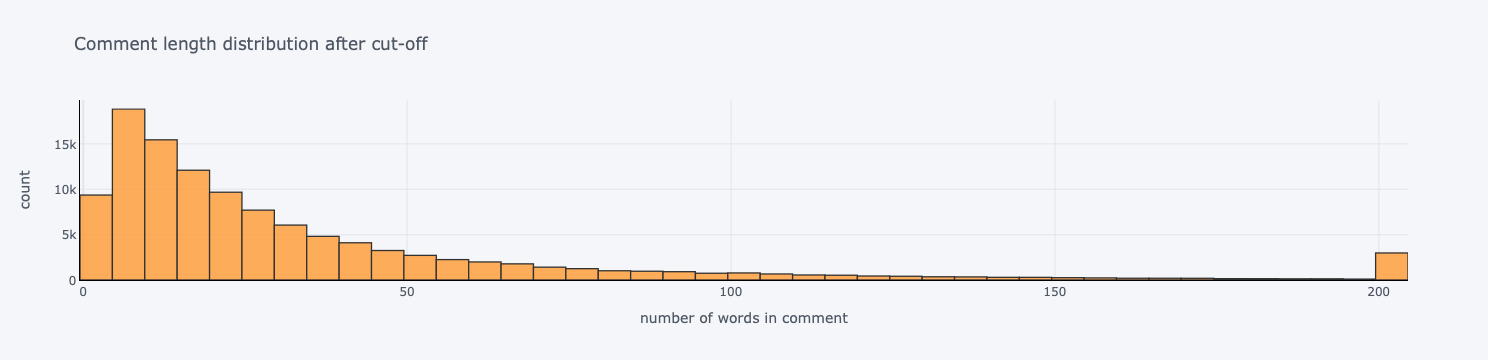

In [21]:
# Length of comments after cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
# length of comments after cut-off
comments['comment_length'] = comments['comment'].apply(lambda x: len(x.split()))
comments['comment_length'].iplot(
    kind='hist',
    bins=50,
    xTitle='number of words in comment',
    linecolor='black',
    yTitle='count',
    title='Comment length distribution after cut-off')

In [22]:
# Split the dataset into three partitions: train, test, and validation

#df_train  = comments.loc[(comments['split'] == 'train')]
#df_test  = comments.loc[(comments['split'] == 'test')]
#df_valid = comments.loc[(comments['split'] == 'dev')]

In [23]:
# Drop unnecessary columns

#df_train = df_train.drop(columns = ['year', 'logged_in', 'ns', 'sample','split', 'comment_length'])
#df_test = df_test.drop(columns = ['year', 'logged_in', 'ns', 'sample','split', 'comment_length'])
#df_valid = df_valid.drop(columns = ['year', 'logged_in', 'ns', 'sample','split', 'comment_length'])

In [24]:
# Create seperate .csv files for each partition

#df_train.to_csv('Data/train.csv', index=False)
#df_test.to_csv('Data/test.csv', index=False)
#df_valid.to_csv('Data/valid.csv', index=False)

In [25]:
nlp = spacy.load('en_core_web_sm')
tokenizer = get_tokenizer(nlp)

In [26]:
# Count of non-attacking and attacking comment in the whole dataset
Counter(comments['attack'])

Counter({0: 102137, 1: 13579})

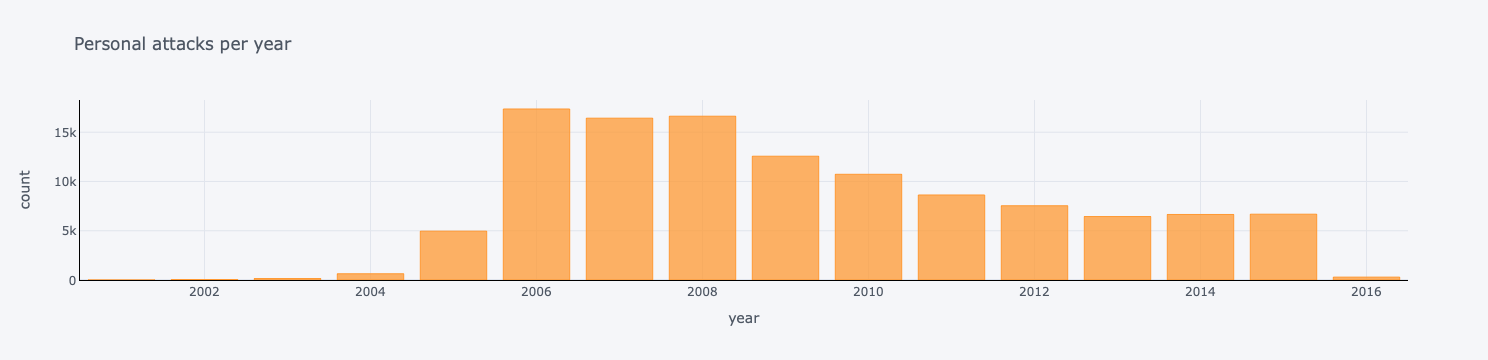

In [27]:
comments.groupby('year').count()['attack'].iplot(
    kind='bar',
    xTitle='year',
    linecolor='black',
    opacity=0.75,
    yTitle='count',
    title='Personal attacks per year')

### Data Pre-Processing

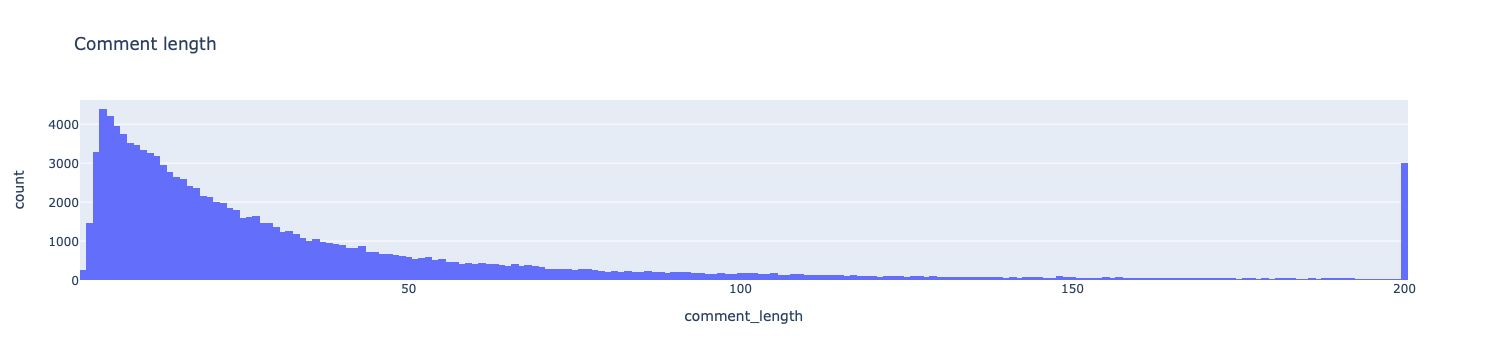

In [28]:
fig = px.histogram(comments, x='comment_length', title='Comment length')
fig.show()

In [59]:
df = comments.drop(columns=['year', 'logged_in', 'ns', 'sample', 'comment_length'])

In [60]:
df

comment  split  attack
rev_id                                                                     
37675      This not creative Those dictionary definitions...  train       0
44816      term standard model less NPOV I think wed pref...  train       0
49851      True false situation March such A Saudi propos...  train       0
89320      Next maybe could work less condescending sugge...    dev       0
93890                          This page need disambiguation  train       0
...                                                      ...    ...     ...
699848324  These sources exactly exude sense impartiality...  train       0
699851288  The Institute Historical Review peerreviewed j...   test       0
699857133  The way trying describe article serious step w...  train       0
699891012  Warning There clearly protectionist regime goi...    dev       0
699897151  Alternate option Is perhaps enough newsworthy ...  train       0

[115716 rows x 3 columns]

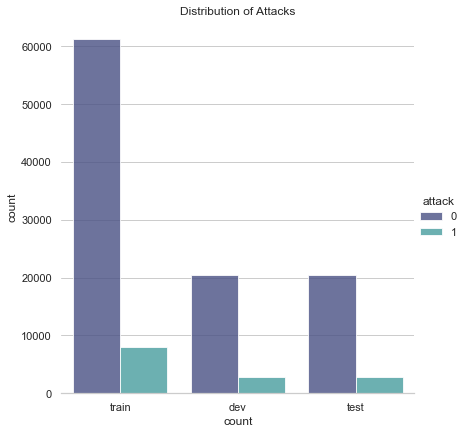

In [74]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df, kind="count",
    x="split", hue="attack",
    ci="sd", palette="mako", alpha=.8, height=6
).set(title='Distribution of Attacks')
g.despine(left=True)
g.set_axis_labels("count")
g.savefig("distribution.png")

##### Word Embedding
Representation of words for text analysis (typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning). The encoded column are words from the tokenised comments from the vocabulary are mapped to vectors of real numbers. Thus this mathematical embedding from space with many dimensions per word to a continuous vector space with a much lower dimension. 

Word and phrase embeddings when used as the underlying input representation have been shown to boost the performance in NLP tasks; syntactic parsing and sentiment analysis. 